In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import curve_fit
import seaborn as sns
import time
import ROOT

Welcome to JupyROOT 6.20/00


In [2]:
sys.path.append('/storage/gpfs_data/neutrino/users/gi/sand-reco/tests/python_tools')
from NLLtreeoutReader import Reader, ROOT_tools, Reader_production
from Helix import Helix
from EventDisplay import EventDisplay
from dg_wire import dg_wire
from Circle import Circle
from Line2D import Line2D
tool = ROOT_tools()

Functions

In [3]:
def FitTH1D_w_chi2( hist, chi2_range: tuple, fit_range: tuple) -> tuple:
    # fit TH1D with chi2 function and return hist, mean and sigma of the fit
    chi2_func = ROOT.TF1("chi2_func", "[0]*ROOT::Math::chisquared_pdf(x, [1])", chi2_range[0], chi2_range[1])
    # Initial guess for the parameters: scale and degrees of freedom
    chi2_func.SetParameters(1, 1)
    # Set the range for the fit
    chi2_func.SetRange(fit_range[0], fit_range[1])
    # Fit the histogram with the chi-squared function
    hist.Fit(chi2_func, "R")
    # Extract the parameters: scale and degrees of freedom
    scale = chi2_func.GetParameter(0)
    dof = chi2_func.GetParameter(1)
    return (hist, scale, dof)

def equally_split_bins(vector_a: np.ndarray, nof_bins: int):
    if isinstance(vector_a, pd.core.series.Series):
        vector_a = vector_a.values
    sorted_indices_a = np.argsort(vector_a)
    vector_a_sorted = vector_a[sorted_indices_a]
    vector_a_subsets = np.array_split(vector_a_sorted, nof_bins)
    centers, widths = [], []
    for subset in vector_a_subsets:
        centers.append(np.mean(subset))
        widths.append(subset[-1]-subset[0])
    return {"x" : centers, "w" : widths}

def calculate_binned_means(df : pd.DataFrame, x_variable : str, bins : list, y_variable : str):
    if len(df) == 0:
        raise ValueError("input dataframe cannot be empty")
    if x_variable not in df.columns:
        raise ValueError("input string x_variable has to be in the dataframe columns")
    if y_variable not in df.columns:
        raise ValueError("input string y_variable has to be in the dataframe columns")
    value = []
    bins = np.array(bins)
    x_centers = (bins[1:] + bins[:-1])/2
    x_widths = (bins[1:] - bins[:-1])/2
    for x, w in zip(x_centers, x_widths):
        value.append(df[(df[x_variable]>=x-w) & 
                      (df[x_variable]<=x+w)][y_variable].mean())
    return {x_variable : x_centers, y_variable : np.array(value), "widths" : x_widths}

In [4]:
def calculate_track_legth_from_wires(wires_event):

    # Seleziona solo le colonne necessarie per il calcolo
    wires_event = wires_event[['hor', 'missing_coordinate', 'x', 'y', 'z']]
    
    # Calcola le coordinate appropriate in base al valore di hor
    wires_event['x_coord'] = np.where(wires_event['hor'], wires_event['missing_coordinate'], wires_event['x'])
    wires_event['y_coord'] = np.where(wires_event['hor'], wires_event['y'], wires_event['missing_coordinate'])
    wires_event['z_coord'] = wires_event['z']
    
    # Calcola le differenze delle coordinate tra fili successivi
    wires_event['x_diff'] = wires_event['x_coord'].diff()
    wires_event['y_diff'] = wires_event['y_coord'].diff()
    wires_event['z_diff'] = wires_event['z_coord'].diff()
    
    # Elimina le righe in cui la differenza della coordinata z è zero
    wires_event = wires_event[wires_event['z_diff'] != 0]
    
    # Calcola la distanza spaziale
    wires_event['distance'] = np.sqrt(wires_event['x_diff']**2 + wires_event['y_diff']**2 + wires_event['z_diff']**2)
    
    # Somma le distanze calcolate
    spatial_sum = wires_event['distance'].sum()

    if(spatial_sum == 0 or spatial_sum>10000):
        print(f"traccia lunga {spatial_sum}")
    
    return spatial_sum

def Glukstern(L, X0, n, pt, dip_angle, p = 1, particle_mass = 0.104):

    '''
    L   = mean muon track length [m]
    X0  = detector radiation length [m]
    n   = mean number of hits
    pt  = transverse momentum
    p   = total momentum

    Return 3 Glukstern terms separately
    '''

    sigma = 200E-6

    B = 0.6 

    gamma  = np.sqrt(1+p**2/particle_mass**2)

    beta = np.sqrt(1-1/gamma**2)

    theta = 13.6E-3/p*np.sqrt(L/X0)*(1+0.038*np.log(L/X0*beta**2))

    position_resolution = np.sqrt(720/(n+4))*((sigma*pt)/(0.3*B*L**2*np.cos(dip_angle)**2))
    # position_resolution = (np.sqrt(720./(n+4)) * ((sigma*pt)/(0.3*B*L*L))) # fastreco
    
    multiple_scattering = 52*1e-3/(B*np.sqrt(X0*L*np.cos(dip_angle)**2))
    # multiple_scattering = (0.045/(B*np.sqrt(L*X0))) # fastreco

    angular_resolution  = abs(theta/np.tan(dip_angle)) 
    
    # print(f"theta {theta}")
    # print(f"sigma_theta {sigma_theta}")
    # print(f"np.tan(theta*sigma_theta) {np.tan(theta*sigma_theta)}")
    # print(f"pt inferred {p*np.sin(theta)}")
    # print(f'position_resolution {np.sqrt(position_resolution)}, multiple_scattering {np.sqrt(multiple_scattering)}, angular_resolution {np.sqrt(angular_resolution)}')

    return (position_resolution, multiple_scattering, angular_resolution)

def GetInfo(df, df_wires, p, bin_width=0.1):
    '''
    p = momentum
    df = dataframe     
    Return:
           - p[GeV] muons mean track length 
           - p[GeV] muons mean nof Y Hits 
           - p[GeV] muons mean transverse momentum 
           - p[GeV] muons mean dip angle 
    '''
    nof_hits_ZY, track_length = [],[]
    df_inrange = df[abs(df.p_true - p) < bin_width/2.]
    if len(df_inrange)==0:
        raise ValueError(f"no values in bin [{p-bin_width},{p+bin_width}]")
    mean_pt = df_inrange.pt_true.mean()
    mean_dip = df_inrange.dip_true.mean()
    event_indices = df_inrange.event_index.values
    for i in event_indices:
        df_wires_inrange = df_wires[(df_wires.event_index == i)]
        track_length.append(calculate_track_legth_from_wires(df_wires_inrange))
        nof_hits_ZY.append(len(df_wires_inrange))
    mean_nof_hits_ZY = np.mean(nof_hits_ZY)
    mean_track_length = np.mean(track_length)
    return (mean_track_length, mean_nof_hits_ZY, mean_pt, mean_dip)

def CalculateGlukTerms(df, df_wires, L, bin_edges):
    path_length, pt, position_term, CMS_term, angular_term = ([] for i in range(5))

    bin_center = (bin_edges[1:]+bin_edges[:-1])/2
    bin_width  = (bin_edges[1:]-bin_edges[:-1])

    # !!! input p is MeV

    for p, width in zip(bin_center, bin_width):
        ###
        path_length, nofHits, pt, dip_angle = GetInfo(df, df_wires, p, width)
        ###
        gluk = Glukstern(path_length, L, nofHits, pt*1e-3, dip_angle, p*1e-3)
        print("-"*30)
        print("")
        print(f"muon p : {p*1e-3} [GeV], <path> : {path_length} [m], <y hits> : {nofHits}, <pt> : {pt*1e-3} [GeV], <dip> : {dip_angle} [mrad]")
        print(f"Glukstern terms : position {gluk[0]}, multiple scattering {gluk[1]}, angle {gluk[2]}")
        print("")
        print("-"*30)
        print
        position_term.append(gluk[0])
        CMS_term.append(gluk[1])
        angular_term.append(gluk[2])

    return position_term, CMS_term, angular_term

Process multiple files

In [5]:
production = "/storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.*.recoNLLmethod.root"

In [6]:
multiple_reader = Reader_production(production)

nof of files in the production 1000


In [7]:
df = multiple_reader.get_dataframe_production(up_2_index=1)
df["pt_res"] = (1/df.pt_true - 1/df.pt_reco)/(1/df.pt_reco)
df["dip_res"] = (df.dip_true - df.dip_reco)
df["p_true"] = np.sqrt(df["p_truefX"]**2 + df["p_truefY"]**2 +df["p_truefZ"]**2)
df["p_reco"] = np.sqrt(df["p_recofX"]**2 + df["p_recofY"]**2 +df["p_recofZ"]**2)

df

processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.0.recoNLLmethod.root


,edep_file,event_index,reco_object/pt_true,reco_object/pt_reco,R_true,R_reco,dip_true,dip_reco,Phi0_true,Phi0_reco,...,p_truefX,p_truefY,p_truefZ,p_recofX,p_recofY,p_recofZ,pt_res,dip_res,p_true,p_reco
0,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,4,2087.319914,2141.946458,11596.221742,11899.702542,0.031322,0.030252,1.444888,1.444431,...,65.400634,-262.116374,2070.796810,64.818744,-269.948173,2124.867669,0.026171,0.001070,2088.344240,2142.926993
1,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,8,2813.323470,2211.322622,15629.574833,12285.125680,-0.096141,-0.096927,1.556050,4.655654,...,-271.313241,-41.483851,2813.017603,-215.010602,-125.391378,2207.764648,-0.213982,0.000786,2826.375740,2221.750953
2,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,12,1327.876229,1268.409648,7377.090162,7046.720266,0.365048,0.357308,1.936244,1.942145,...,507.483145,474.540001,1240.188319,473.539304,460.270913,1181.953350,-0.044783,0.007739,1421.546490,1353.921160
3,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,22,1717.098645,1831.081297,9539.436919,10172.673874,0.154352,0.164234,1.092703,1.092845,...,267.161828,-790.014618,1524.567041,303.459916,-842.225262,1625.889088,0.066381,-0.009883,1737.758096,1856.056744
4,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,27,5394.161937,NaN,29967.566319,NaN,-0.318154,NaN,1.338768,NaN,...,-1776.526453,-1240.399640,5249.608723,NaN,NaN,NaN,NaN,NaN,5679.175050,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,970,1780.523224,1660.826841,9891.795692,9226.815785,0.006530,0.009609,1.450968,1.442610,...,11.627713,-212.846378,1767.755462,15.959214,-212.313237,1647.200318,-0.067225,-0.003078,1780.561192,1660.903517
161,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,976,167.344609,128.973918,929.692272,716.521767,-0.994989,1.382611,0.468025,0.714039,...,-257.773335,-149.348541,75.493255,677.247430,-97.468510,84.463963,-0.229291,-2.377600,307.329319,689.418851
162,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,980,665.089320,654.134975,3694.940668,3634.083195,-0.636601,-0.668296,1.349928,1.348040,...,-491.683260,-145.705597,648.932726,-516.429171,-144.510668,637.972752,-0.016470,0.031695,827.101101,833.421654
163,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,990,1543.326805,1666.572195,8574.037805,9258.734416,0.261615,0.261600,1.613592,1.610884,...,413.228204,66.027065,1541.913763,446.200865,66.791572,1665.233247,0.079857,0.000015,1597.690576,1725.270440


In [7]:
fit_zy = multiple_reader.get_dataframe_fit_zy(up_2_index=100)
chi2_zy = fit_zy.groupby(['edep_file','event_index'])['MinValue'].mean().values

processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.0.recoNLLmethod.root


processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.1.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.2.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.3.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.4.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.5.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.6.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.7.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY

In [27]:
# fit_xz = multiple_reader.get_dataframe_fit_xz(up_2_index=20)
# # fit_xz.dropna()
# chi2_xz = fit_xz.groupby(['edep_file','event_index'])['MinValue'].mean().values

processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.0.recoNLLmethod.root


processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.1.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.2.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.3.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.4.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.5.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.6.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.7.recoNLLmethod.root
processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY

In [8]:
wires = multiple_reader.get_dataframe_wire(up_2_index=1)
nof_fired_wires_per_event = wires.groupby(["edep_file","event_index"]).size().values

processing file /storage/gpfs_data/neutrino/users/gi/SAND-DRIFT-STUDY/geometry/production/events-in-SANDtracker.0.recoNLLmethod.root


In [9]:
lengths = []
for i in wires.event_index.unique():
    lengths.append(calculate_track_legth_from_wires(wires[wires.event_index==i]))

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

traccia lunga 0.0
traccia lunga 0.0
traccia lunga 0.0
traccia lunga 0.0
traccia lunga 0.0
traccia lunga 0.0
traccia lunga 0.0


/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

traccia lunga 0.0
traccia lunga 0.0


/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

traccia lunga 0.0
traccia lunga 54709.96398980968
traccia lunga 0.0
traccia lunga 0.0


/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

traccia lunga 0.0
traccia lunga 0.0
traccia lunga 0.0
traccia lunga 0.0
traccia lunga 46029.698644180404
traccia lunga 0.0
traccia lunga 0.0


/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

traccia lunga 18245.293528477476


/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

(array([162.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([    0.        ,  5470.99639898, 10941.99279796, 16412.98919694,
        21883.98559592, 27354.9819949 , 32825.97839389, 38296.97479287,
        43767.97119185, 49238.96759083, 54709.96398981]),
 <BarContainer object of 10 artists>)

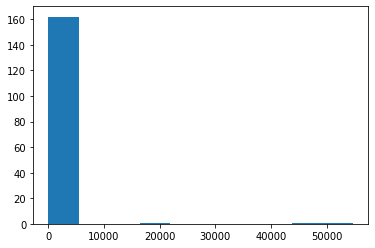

In [11]:
plt.hist(lengths)

In [10]:
len(df)

165

Complete Dataframe

In [39]:
df["nof_fired_wires"] = nof_fired_wires_per_event

In [12]:
df["chi2_zy"] = chi2_zy

In [60]:
df["chi2_xz"] = chi2_xz

NameError: name 'chi2_xz' is not defined

In [61]:
df = df.dropna(subset=["pt_reco", "dip_reco"])

In [62]:
len(df)

14391

In [14]:
df['chi2_zy_over_nof_wires'] = np.sqrt(df["chi2_zy"]) / df["nof_fired_wires"]

In [15]:
ChiSquareFit_nof_wires = calculate_binned_means(df, x_variable='nof_fired_wires', bins = equally_split_bins(df['nof_fired_wires'], nof_bins=10)['x'], y_variable='chi2_zy_over_nof_wires')
# ChiSquareFit_pt_true = calculate_binned_means(df, x_variable='pt_true', bins = equally_split_bins(df['pt_true'], nof_bins=8)['x'], y_variable='chi2_zy_over_nof_wires')

In [16]:
# ChiSquareFit_nof_wires = calculate_binned_means(df, x_variable='nof_fired_wires', bins = [0,10,25,50,70,100,200,500,700,1e3], y_variable='chi2_zy_over_nof_wires')
ChiSquareFit_pt_true = calculate_binned_means(df, x_variable='pt_true', bins = [0,250,500,750,1000,1500,2000,5000], y_variable='chi2_zy_over_nof_wires')

Text(0, 0.5, '$\\frac{\\sqrt{\\chi^2_{yz}}}{n}$')

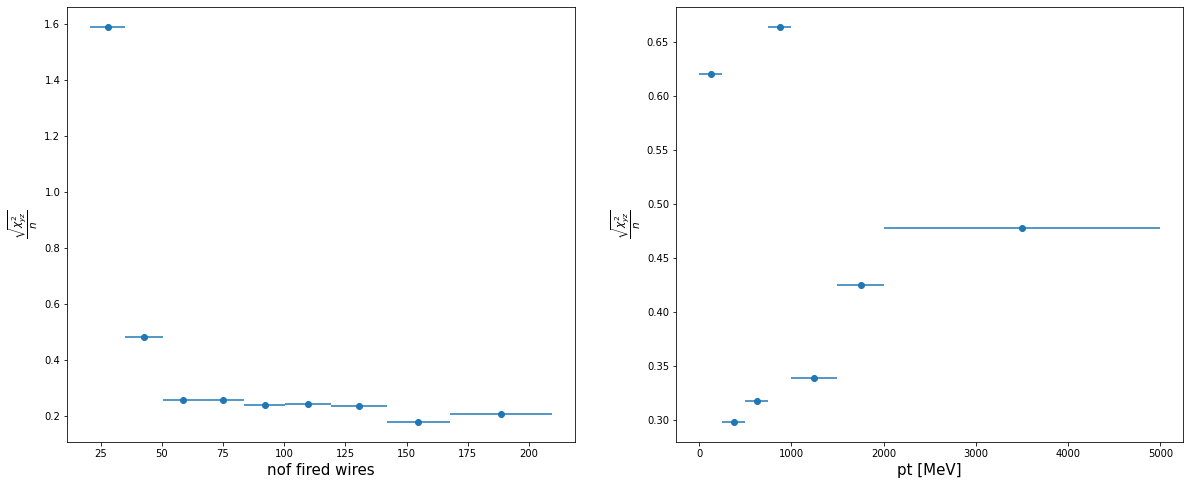

In [17]:
fig,ax = plt.subplots(1,2,figsize=(20,8))

ax[0].errorbar(x = ChiSquareFit_nof_wires["nof_fired_wires"], y = ChiSquareFit_nof_wires["chi2_zy_over_nof_wires"], xerr=ChiSquareFit_nof_wires["widths"], fmt='o')
ax[1].errorbar(x = ChiSquareFit_pt_true["pt_true"], y = ChiSquareFit_pt_true["chi2_zy_over_nof_wires"], xerr = ChiSquareFit_pt_true["widths"], fmt='o')

ax[0].set_xlabel('nof fired wires', fontsize=15)
ax[0].set_ylabel(r"$\frac{\sqrt{\chi^2_{yz}}}{n}$", fontsize=15)
# ax[0].set_xscale('log')
# ax[0].set_ylim([0,200])

ax[1].set_xlabel('pt [MeV]', fontsize=15)
ax[1].set_ylabel(r"$\frac{\sqrt{\chi^2_{yz}}}{n}$", fontsize=15)
# ax[1].set_xscale('log')

# plt.suptitle(r"$\chi^2_{yz}$ value", fontsize=20)

Text(0.5, 0, '$p_{t}$ true')

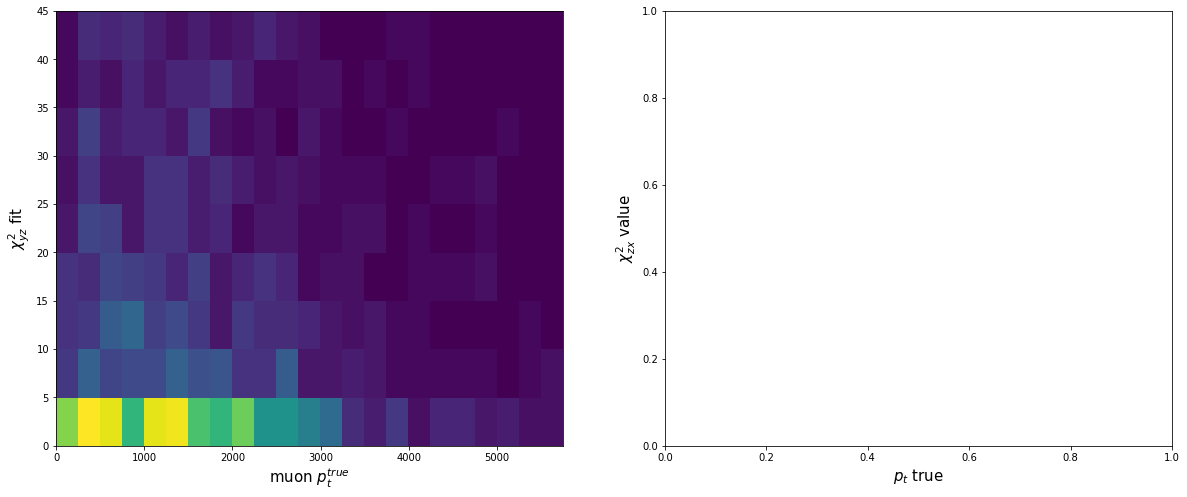

In [25]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].hist2d(x=df["pt_true"], y=df["chi2_zy"], bins=(np.arange(0,6,0.25)*1e3, np.arange(0,50,5)))
# ax[1].hist2d(x=df["pt_true"], y=df["chi2_xz"], bins=(np.arange(0,6,0.25)*1e3, np.arange(0,400,10)))

# plt.colorbar()
ax[0].set_ylabel(r"$\chi^2_{yz}$ fit", fontsize=15)
ax[0].set_xlabel(r"muon $p_{t}^{true}$ ", fontsize=15)

ax[1].set_ylabel(r"$\chi^2_{zx}$ value", fontsize=15)
ax[1].set_xlabel(r"$p_{t}$ true", fontsize=15)

Text(0, 0.5, '$p_{t}$ resolution')

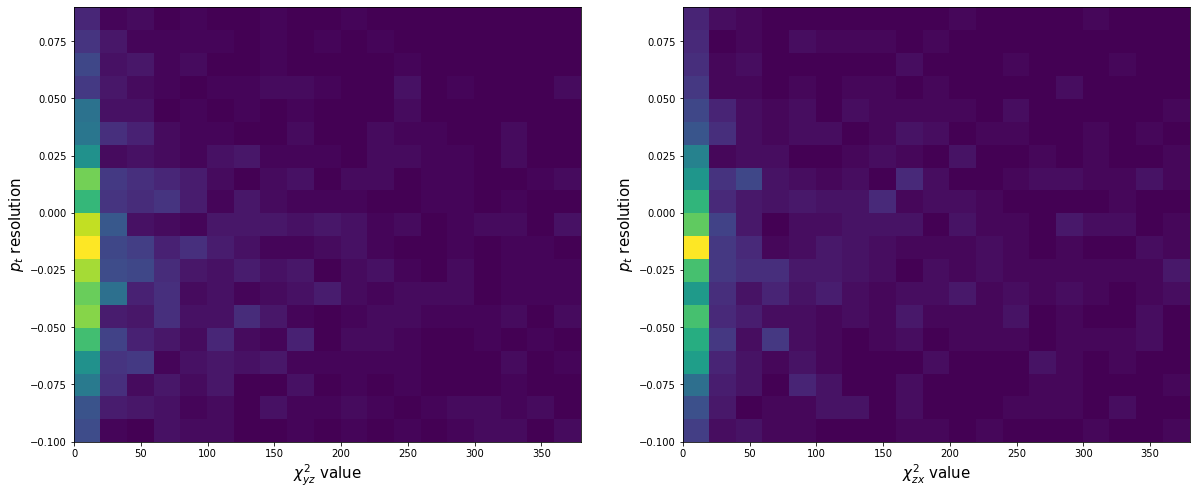

In [44]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].hist2d(x=df["chi2_zy"], y=df["pt_res"], bins=(np.arange(0,400,20), np.arange(-0.1,0.1,0.01)))
ax[1].hist2d(x=df["chi2_xz"], y=df["pt_res"], bins=(np.arange(0,400,20), np.arange(-0.1,0.1,0.01)))

# plt.colorbar()
ax[0].set_xlabel(r"$\chi^2_{yz}$ value", fontsize=15)
ax[0].set_ylabel(r"$p_{t}$ resolution", fontsize=15)

ax[1].set_xlabel(r"$\chi^2_{zx}$ value", fontsize=15)
ax[1].set_ylabel(r"$p_{t}$ resolution", fontsize=15)

In [28]:
df

,edep_file,event_index,reco_object/pt_true,reco_object/pt_reco,R_true,R_reco,dip_true,dip_reco,Phi0_true,Phi0_reco,...,z0_true,x0_reco,y0_reco,z0_reco,pt_true,pt_reco,nof_fired_wires,chi2_zy,pt_res,dip_res
0,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,4,2087.319914,2141.946458,11596.221742,11899.702542,0.031322,0.030252,1.444888,1.444431,...,24818.566863,449.083881,-1782.207219,24818.566863,2087.319914,2141.946458,78,2.027217,0.026171,0.001070
1,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,8,2813.323470,2211.322622,15629.574833,12285.125680,-0.096141,-0.096927,1.556050,4.655654,...,24712.290061,596.045499,-3101.703636,24712.290061,2813.323470,2211.322622,54,6915.595121,-0.213982,0.000786
2,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,12,1327.876229,1268.409648,7377.090162,7046.720266,0.365048,0.357308,1.936244,1.942145,...,23357.979022,-1271.286702,-1379.290980,23357.979022,1327.876229,1268.409648,141,634.540055,-0.044783,0.007739
3,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,22,1717.098645,1831.081297,9539.436919,10172.673874,0.154352,0.164234,1.092703,1.092845,...,24556.800360,1360.691831,-1793.418619,24556.800360,1717.098645,1831.081297,112,78.980899,0.066381,-0.009883
5,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,32,1896.313408,57.929446,10535.074487,321.830253,0.314684,0.273909,1.914336,2.194406,...,25615.614999,-939.158189,-2722.322672,25615.614999,1896.313408,57.929446,15,2377.956173,-0.969452,0.040775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3389,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,958,2034.575083,2141.026565,11303.194906,11894.592026,-0.162398,-0.163352,1.491707,1.492155,...,24817.486794,-1192.209928,-2297.811104,24817.486794,2034.575083,2141.026565,30,246.194388,0.052321,0.000953
3391,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,969,322.131150,285.361199,1789.617501,1585.339994,1.114372,1.241666,0.990356,1.008569,...,24747.380085,-1111.233989,-2031.805136,24747.380085,322.131150,285.361199,209,860.548535,-0.114146,-0.127294
3392,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,978,1181.879267,1162.630995,6565.995926,6459.061085,0.098345,0.100843,1.305124,1.302190,...,24711.498674,-90.156650,-2346.972323,24711.498674,1181.879267,1162.630995,157,69.921331,-0.016286,-0.002498
3394,/storage/gpfs_data/neutrino/users/gi/SAND-DRIF...,989,264.999201,225.213594,1472.217784,1251.186634,-0.726146,-0.768379,1.121647,1.134263,...,24940.508206,-399.521149,-3369.822196,24940.508206,264.999201,225.213594,107,238.952824,-0.150135,0.042233


In [87]:
chi2_zy_hist = tool.FillTH1D(iterable=chi2_zy, histogram_name="chi2_zy", title="chi2_zy", x_min=0, x_max=100, nbins=50)
FitTH1D_w_chi2(hist=chi2_zy_hist, chi2_range=(0,2), fit_range=(0,3))

(<ROOT.TH1D object ("chi2_zytime:1715805727") at 0xb2237e0>,
 59235.416416759654,
 2.3492272292759036)

 FCN=2.97675e-07 FROM MIGRAD    STATUS=CONVERGED      69 CALLS          70 TOTAL
                     EDM=5.95347e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.92354e+04   3.76422e+02   1.83032e-01  -2.08478e-06
   2  p1           2.34923e+00   2.49996e-02   1.21832e-05   3.24185e-02


 FCN=843.599 FROM MIGRAD    STATUS=CONVERGED      55 CALLS          56 TOTAL
                     EDM=1.20389e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.96619e+04   1.81398e+02   2.56428e+00  -8.53182e-08
   2  p1           2.23036e+00   1.73921e-02   2.45979e-04   1.69655e-04


Warning in <TCanvas::Constructor>: Deleting canvas with same name: chi2_zy_hist


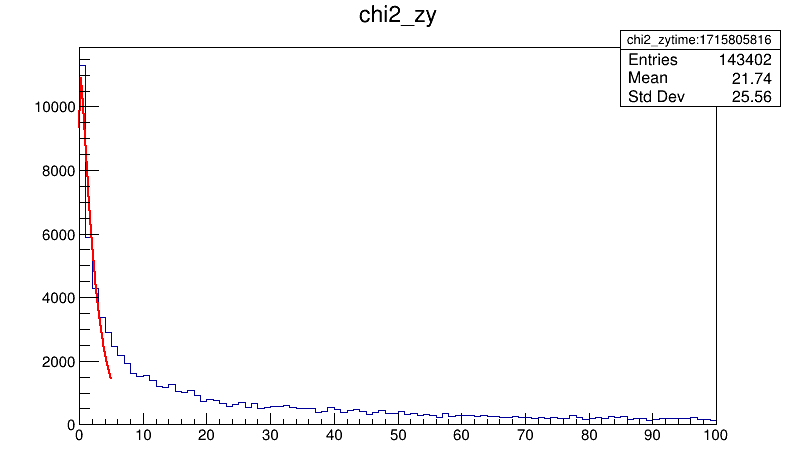

In [92]:
chi2_zy_hist = tool.FillTH1D(iterable=chi2_zy, histogram_name="chi2_zy", title="chi2_zy", x_min=0, x_max=100, nbins=100)
FitTH1D_w_chi2(hist=chi2_zy_hist, chi2_range=(0,2), fit_range=(0,5))
canvas_name = "chi2_zy_hist"
canvas = ROOT.TCanvas(canvas_name, "Canvas",800, 500)
chi2_zy_hist.Draw()
# canvas.SetLogx()
canvas.Draw()

 FCN=917.091 FROM MIGRAD    STATUS=CONVERGED      55 CALLS          56 TOTAL
                     EDM=1.22751e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.55369e+04   1.79778e+02   2.50643e+00   1.42799e-08
   2  p1           1.68212e+00   1.94899e-02   2.71831e-04  -7.50348e-04


Warning in <TCanvas::Constructor>: Deleting canvas with same name: chi2_xz_hist


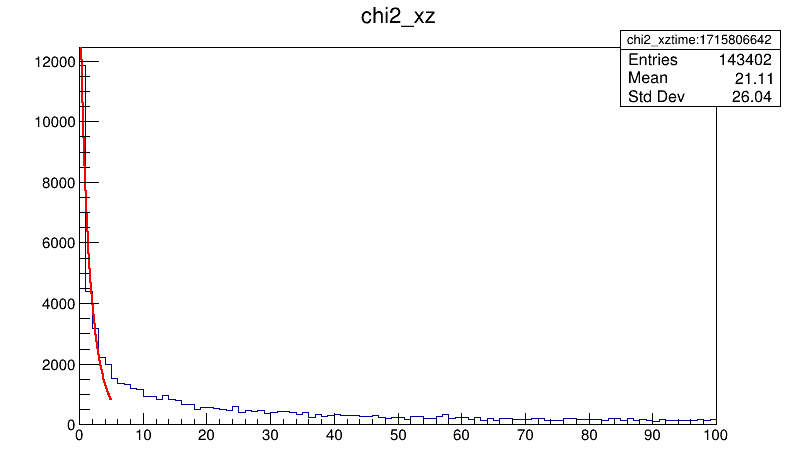

In [99]:
chi2_xz_hist = tool.FillTH1D(iterable=chi2_xz, histogram_name="chi2_xz", title="chi2_xz", x_min=0, x_max=100, nbins=100)
FitTH1D_w_chi2(hist=chi2_xz_hist, chi2_range=(0,2), fit_range=(0,5))
canvas_name = "chi2_xz_hist"
canvas = ROOT.TCanvas(canvas_name, "Canvas",800, 500)
chi2_xz_hist.Draw()
# canvas.SetLogx()
canvas.Draw()

 FCN=954.86 FROM MIGRAD    STATUS=CONVERGED      72 CALLS          73 TOTAL
                     EDM=2.42042e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.91127e+03   7.62538e+00   8.61241e-02   3.78925e-05
   2  Mean        -2.16780e-02   1.73476e-04   2.49200e-06   3.73775e-01
   3  Sigma        4.84316e-02   1.72273e-04   1.38872e-05   1.77327e-01
 FCN=3020.62 FROM MIGRAD    STATUS=CONVERGED      69 CALLS          70 TOTAL
                     EDM=1.32687e-10    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   3.5 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.97270e+03   1.76572e+01   9.15791e-03   1.30603e-06
   2  Mean         8.09475e-06   1.02755e-05  -1.62709e-08  -4.06170e-01
   3  Sigma        2.

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


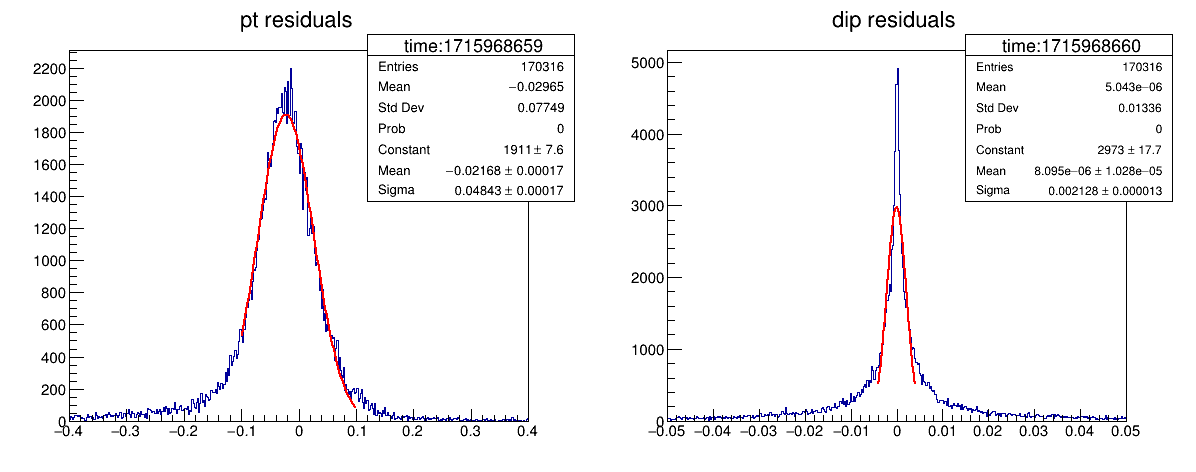

In [7]:
hist_pt = tool.FillTH1D(iterable = df['pt_res'].values, 
                     histogram_name = "", 
                     title = "pt residuals", 
                     nbins = int(np.sqrt(len(df))),
                    #  nbins = 30,
                     x_min = -0.4, 
                     x_max = 0.4)
hist_pt, mean, sigma = tool.FitTH1D_w_gauss(hist = hist_pt, 
                                             gauss_range = (-0.2, 0.2), 
                                             fit_range = (-0.1,0.1))
hist_dip = tool.FillTH1D(iterable = df['dip_res'].values, 
                     histogram_name = "", 
                     title = "dip residuals", 
                     nbins = int(np.sqrt(len(df))),
                    #  nbins = 30,
                     x_min = -0.05, 
                     x_max = 0.05)
hist_dip, mean, sigma = tool.FitTH1D_w_gauss(hist = hist_dip, 
                                             gauss_range = (-0.05, 0.05), 
                                             fit_range = (-0.004,0.004))

c = ROOT.TCanvas("canvas_name", "Canvas", 1200, 500)
ROOT.gStyle.SetOptFit(1011)
c.Divide(2,1)
c.cd(1)
hist_pt.Draw()
c.cd(2)
hist_dip.Draw()
c.Draw()                                             

In [30]:
# centers, widths = equally_split_bins(df['pt_true'].values, nof_bins=10)
bin_edges  = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 5, 8])*1e3
centers = (bin_edges[1:]+bin_edges[:-1])/2
widths  = (bin_edges[1:]-bin_edges[:-1])

resolutions, hists = [], []

# df_cut = df[(df.TMinuitFinalStatus==1)&(df.nof_digits>10)]
df_cut = df
for pt, width in zip(centers, widths):
    # select all events in a give range of pt
    print(pt)
    df_inrange = df_cut[abs(df_cut.pt_true - pt) <= width/2]
    hist = tool.FillTH1D(iterable = df_inrange['pt_res'].values, 
                         histogram_name = "", 
                         title = "", 
                         nbins = int(np.sqrt(len(df_inrange))),
                        #  nbins = 30,
                         x_min = -0.4, 
                         x_max = 0.4)
    hist, mean, sigma = tool.FitTH1D_w_gauss(hist = hist, 
                                             gauss_range = (-0.2, 0.2), 
                                             fit_range = (-0.1,0.1))
    print(f"energy range [{pt - width/2},{pt + width/2}] : resolution {sigma}")
    hists.append(hist)
    resolutions.append(sigma)

250.0
energy range [0.0,500.0] : resolution 0.07796714166254337
750.0
energy range [500.0,1000.0] : resolution 0.05281095166910471
1250.0
energy range [1000.0,1500.0] : resolution 0.04609628277813518
1750.0
energy range [1500.0,2000.0] : resolution 0.04331104227928899
2250.0
energy range [2000.0,2500.0] : resolution 0.04193293807026906
2750.0
energy range [2500.0,3000.0] : resolution 0.04345667075884719
4000.0
energy range [3000.0,5000.0] : resolution 0.03867854959652307
6500.0
energy range [5000.0,8000.0] : resolution 0.039463976698872735
 FCN=353.082 FROM MIGRAD    STATUS=CONVERGED      97 CALLS          98 TOTAL
                     EDM=1.18205e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.94257e+02   8.24008e+00   4.34252e-02  -1.15507e-05
   2  Mean        -8.82520e-02   3.71738e-03   7.68510e-06  -8.89699e-02
   3  S

Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969387 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969387 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969387 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969387 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969387 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969387 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969387 (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_name


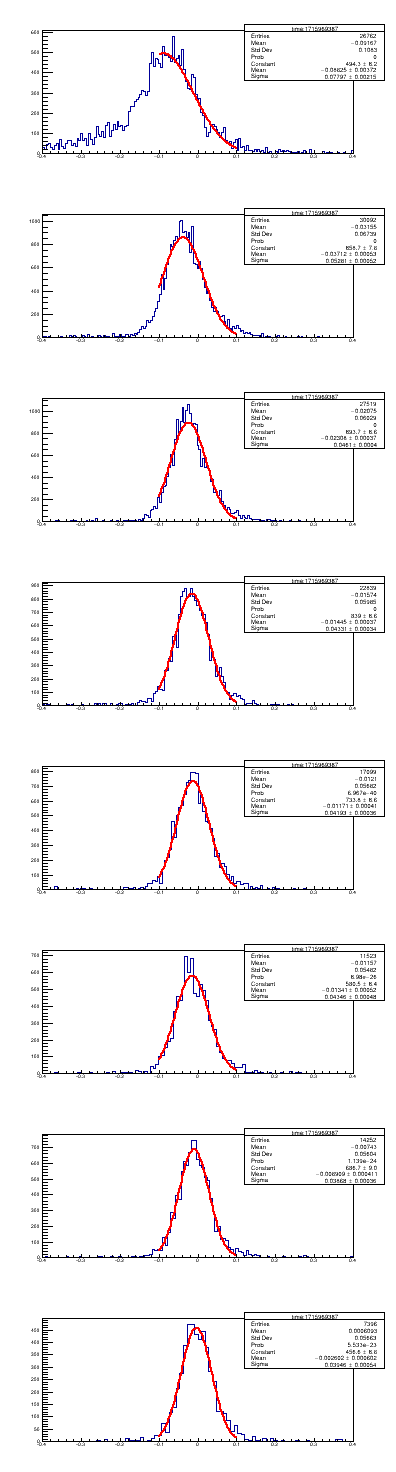

In [31]:
c = ROOT.TCanvas("canvas_name", "Canvas", 400, 1500)
ROOT.gStyle.SetOptFit(1011)
c.Divide(1,len(hists))
for i, hist in enumerate(hists):
    c.cd(i+1)
    hist.Draw()
c.Draw()

No handles with labels found to put in legend.


Text(0.5, 0.98, '$\\mu$ momentum (transverse to B) resolution')

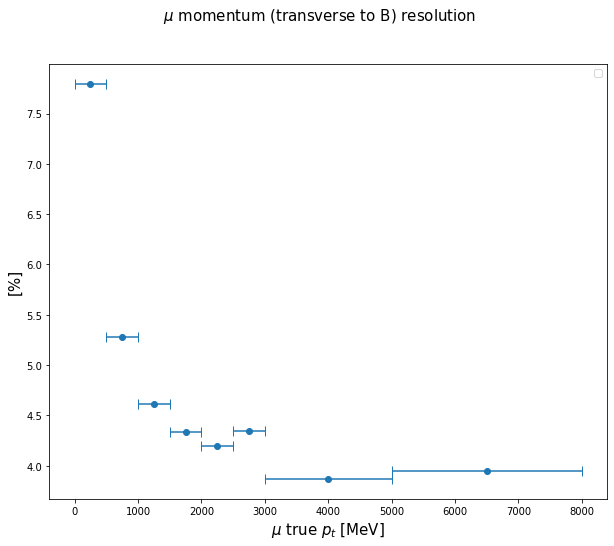

In [32]:
fig,ax = plt.subplots(figsize=(10,8))
ax.errorbar(x=centers, y=np.array(resolutions)*1E2, xerr=np.array(widths)/2 ,fmt ='o',capsize=5)
plt.xlabel(r"$\mu$ true $p_t$ [MeV]", fontsize=15)
plt.ylabel("[%]", fontsize=15)
# plt.xticks(np.arange(0,6,0.5))
# plt.yticks(np.arange(0.1,2,0.1))
plt.legend()
plt.suptitle(r"$\mu$ momentum (transverse to B) resolution", fontsize=15)

Glukestern

In [ ]:
df['estimated_track_length'] = [GetEstimatedTrackLength(wires[wires.event_index == i]) for i in df.event_index.values]

In [ ]:
df

end glukestern

In [20]:
centers =  equally_split_bins(df['dip_true'].values, nof_bins=10)['x']
widths =  equally_split_bins(df['dip_true'].values, nof_bins=10)['w']

resolutions, hists = [], []

# df_cut = df[(df.TMinuitFinalStatus==1)&(df.nof_digits>10)]
df_cut = df
for dip, width in zip(centers, widths):
    # select all events in a give range of pt
    print(dip, width)
    df_inrange = df_cut[abs(df_cut.dip_true - dip) <= width/2]
    hist = tool.FillTH1D(iterable = df_inrange['dip_res'].values, 
                         histogram_name = "", 
                         title = "", 
                         nbins = int(np.sqrt(len(df_inrange))),
                        #  nbins = 30,
                         x_min = -0.05, 
                         x_max = 0.05)
    hist, mean, sigma = tool.FitTH1D_w_gauss(hist = hist, 
                                             gauss_range = (-0.05, 0.05), 
                                             fit_range = (-0.005,0.005))
    print(f"energy range [{pt - width/2},{pt + width/2}] : resolution {sigma}")
    hists.append(hist)
    resolutions.append(sigma)

-0.7519793434557736 1.0428087805287516
energy range [6499.478595609736,6500.521404390264] : resolution 0.0039515339983409
-0.36128508682442256 0.20523187396531983
energy range [6499.897384063017,6500.102615936983] : resolution 0.0037393111453491333
-0.20885093026189838 0.11698056139257754
energy range [6499.941509719304,6500.058490280696] : resolution 0.002681392621313518
-0.11134624075835522 0.08384813870710595
energy range [6499.958075930646,6500.041924069354] : resolution 0.0022331092304758667
-0.03532305575921829 0.06902338918326502
energy range [6499.965488305408,6500.034511694592] : resolution 0.0018683059295652252
0.03103447009917463 0.0662271824159006
energy range [6499.966886408792,6500.033113591208] : resolution 0.0017613838522888463
0.10135503247915306 0.0797133269236146
energy range [6499.960143336538,6500.039856663462] : resolution 0.002153649445007303
0.19714773297852778 0.11309985145215559
energy range [6499.943450074274,6500.056549925726] : resolution 0.0026556418453092

Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969148 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969148 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969148 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969148 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969148 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969148 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969148 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969148 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1:  time:1715969148 (Potential memory leak).


No handles with labels found to put in legend.


Text(0.5, 0.98, '$\\mu$ dip angle resolution')

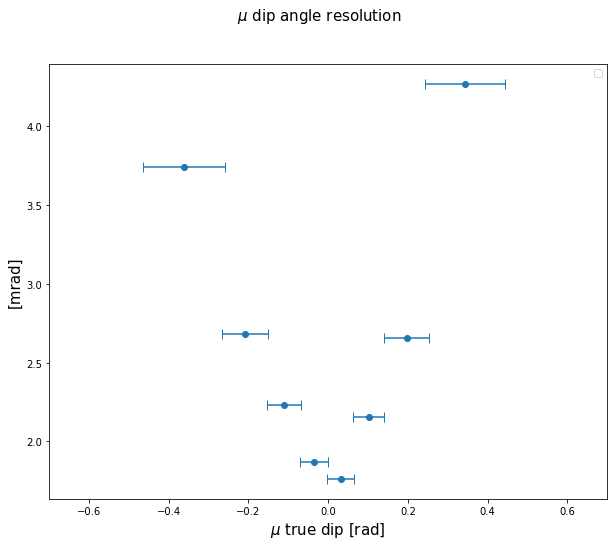

In [28]:
fig,ax = plt.subplots(figsize=(10,8))
ax.errorbar(x=centers[1:-1], y=np.array(resolutions[1:-1])*1e3, xerr=np.array(widths[1:-1])/2 ,fmt ='o',capsize=5)
plt.xlabel(r"$\mu$ true dip [rad]", fontsize=15)
plt.ylabel("[mrad]", fontsize=15)
# plt.xticks(np.arange(0,6,0.5))
# plt.yticks(np.arange(0.1,2,0.1))
plt.legend()
plt.xlim(-0.7,0.7)
plt.suptitle(r"$\mu$ dip angle resolution",fontsize=15)

Wires Info

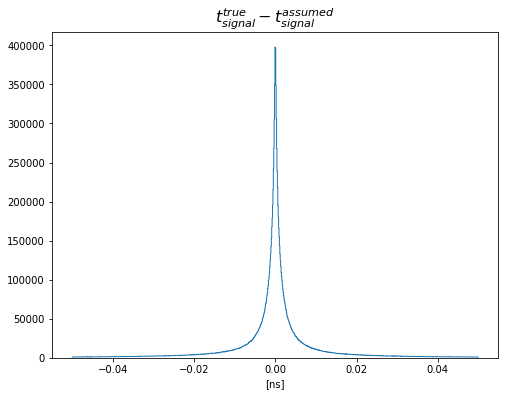

In [19]:
fig, ax = plt.subplots(figsize=(8,6))

plt.hist(x = (wires["signal_time"]-wires["signal_time_measured"]).values, bins=np.arange(-0.05,0.05,1e-4), histtype="step")

ax.set_title(r"$t^{true}_{signal} - t^{assumed}_{signal}$", fontsize=16)
ax.set_xlabel("[ns]")
plt.savefig("/storage/gpfs_data/neutrino/users/gi/sand-reco/tests/plots/good_for_thesis/t_signal_residuals.png")

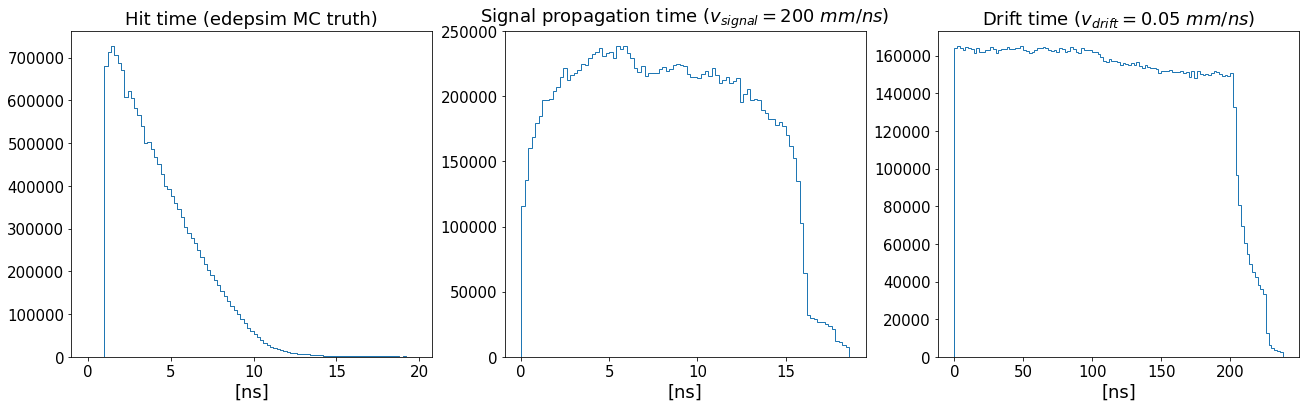

In [24]:
fig, ax = plt.subplots(1,3, figsize=(22,6))

ax[0].hist(x = wires.t_hit.values, histtype="step", bins=np.arange(0,20,0.2))
ax[1].hist(x = wires.signal_time.values, histtype="step", bins=np.arange(0,wires.signal_time.values.max(),0.2))
ax[2].hist(x = wires.drift_time.values, histtype="step", bins=np.arange(0,240,2))

ax[0].set_title(r"Hit time (edepsim MC truth)", fontsize=18)
ax[0].set_xlabel("[ns]", fontsize=18)
ax[0].tick_params(labelsize=15)

ax[1].set_title(r"Signal propagation time ($v_{signal} = 200$ $mm / ns$)", fontsize=18)
# ax[1].vlines(x=3800/200,ymin=0,ymax=80000, colors='orange')
ax[1].set_xlabel("[ns]", fontsize=18)
ax[1].tick_params(labelsize=15)

ax[2].set_title(r"Drift time ($v_{drift} = 0.05$ $mm / ns$)", fontsize=18)
ax[2].set_xlabel("[ns]", fontsize=18)
ax[2].tick_params(labelsize=15)
# ax[2].vlines(x=np.sqrt(5.01*5.01+10.14*10.14)/0.05,ymin=0,ymax=80000, colors='orange')

Investigate unreconstructed events

In [40]:
some_problematic = df[(df.pt_res>1)&(df.pt_true > 500)&(df.pt_true < 5000)&(df.nof_fired_wires>100)]

In [41]:
some_problematic

,edep_file,event_index,reco_object/pt_true,reco_object/pt_reco,R_true,R_reco,dip_true,dip_reco,Phi0_true,Phi0_reco,...,p_truefY,p_truefZ,p_recofX,p_recofY,p_recofZ,pt_res,dip_res,p_true,p_reco,nof_fired_wires


In [42]:
all_wires = pd.read_csv("/storage/gpfs_data/neutrino/users/gi/sand-reco/wireinfo.txt")
def FastDisplay(edep_file : str, reco_file : str, edep_event_number : int):
    reader = Reader(reco_file, "tReco")
    helix_true = reader.get_true_helix(edep_event_number)
    helix_reco = reader.get_reco_helix(edep_event_number)
    fit_xz = reader.get_fit_xz(edep_event_number)
    fit_zy = reader.get_fit_zy(edep_event_number)
    wires = reader.get_wire_info(edep_event_number)

    fitted_circle = Circle(fit_zy['value'].values[0], 
                       fit_zy['value'].values[1],
                       fit_zy['value'].values[2])
    fitted_line = Line2D.from_mq(fit_xz['value'].values[0],
                             fit_xz['value'].values[1])
    initial_guess_circle = Circle( fit_zy['initial_guess'].values[0], 
                               fit_zy['initial_guess'].values[1],
                               fit_zy['initial_guess'].values[2])
    initial_guess_line = Line2D.from_mq(fit_xz['initial_guess'].values[0],
                                    fit_xz['initial_guess'].values[1])
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    display = EventDisplay(arg_file_name = edep_file, 
                       arg_event_idx = edep_event_number,
                       fig = fig,
                       ax_0 = ax[0], 
                       ax_1 = ax[1],
                       arg_fired_wires_info = wires)
    display.reset_zoom()
    display.plot_sand()

    display.plot_wires(color='orange', label ='fired wires', alpha=1)
    display.plot_wires_from_csv_table(all_wires)

    display.plot_helix(helix_true, label = 'true helix', color = 'blue', linewidth = 3)
    # display.plot_helix(helix_reco, label = 'reco helix', color = 'green')

    display.plot_line(line = fitted_line, label = 'fitted', color = 'orange', linewidth = 2, linestyle='solid')
    display.plot_circle(circle = fitted_circle, label = 'fitted', color = 'orange', linewidth = 2, linestyle='solid')

    # display1.plot_line(line = initial_guess_line, label = 'initial guess', color = 'green')

    display.set_figure(labelsize=20, numbersize=20)

    ax[0].set_title("Zoom on wires in XZ view", fontsize = 20)
    ax[1].set_title("Zoom on wires in ZY view", fontsize = 20)

display 0 true pt 3090.8697760304717


display 1 true pt 2024.145603116853
display 2 true pt 4328.086165212919
display 3 true pt 2476.158962444525
display 4 true pt 2587.115004805733
display 5 true pt 1783.8197633291156
display 6 true pt 3210.589209143019
display 7 true pt 2646.4756490109453
display 8 true pt 2029.9095944878422
display 9 true pt 3357.447234572574
display 10 true pt 4174.268916322364
display 11 true pt 3255.7225323882258
display 12 true pt 3079.083212620142
display 13 true pt 1747.8029625843667


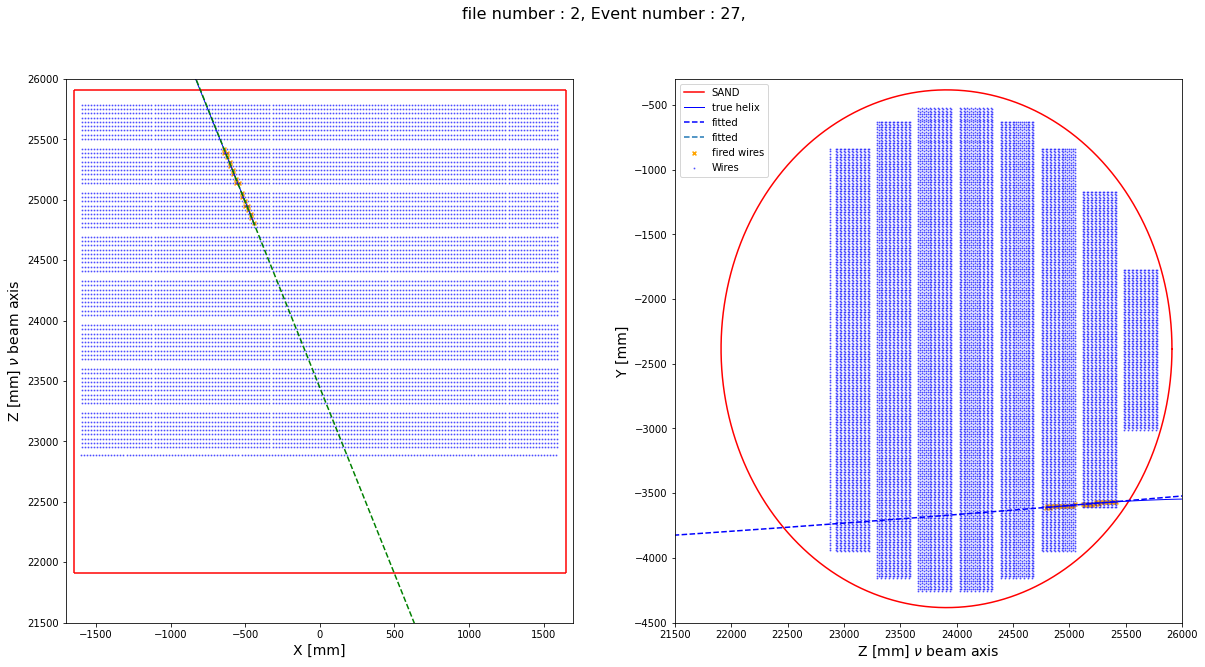

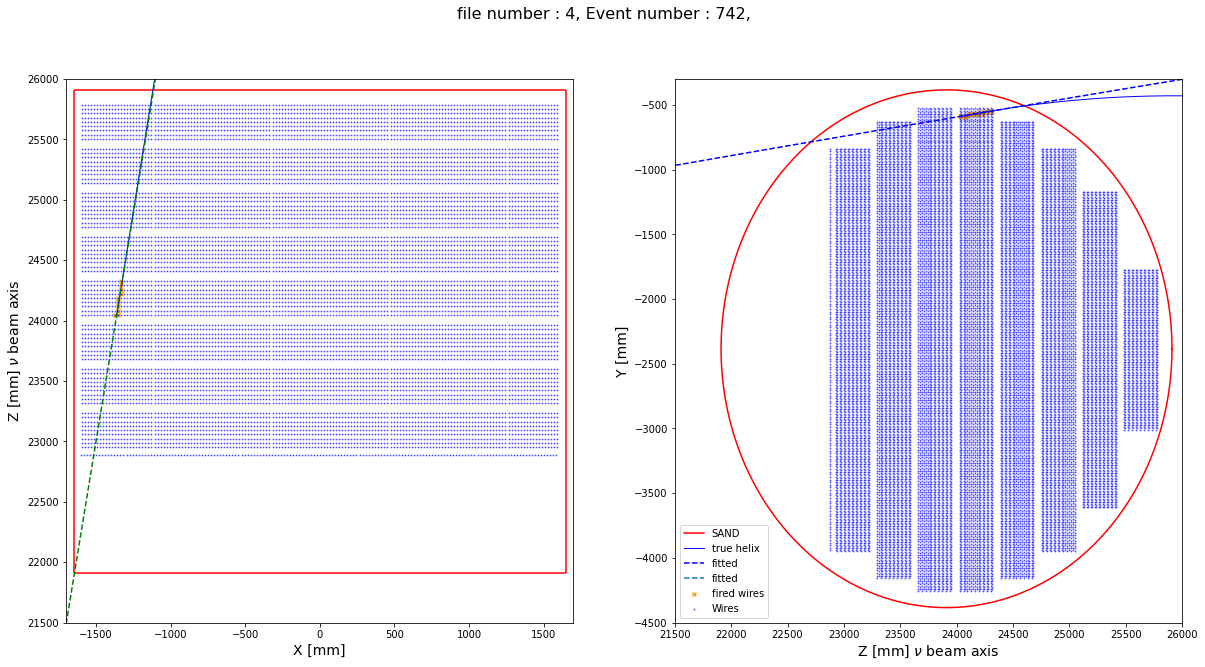

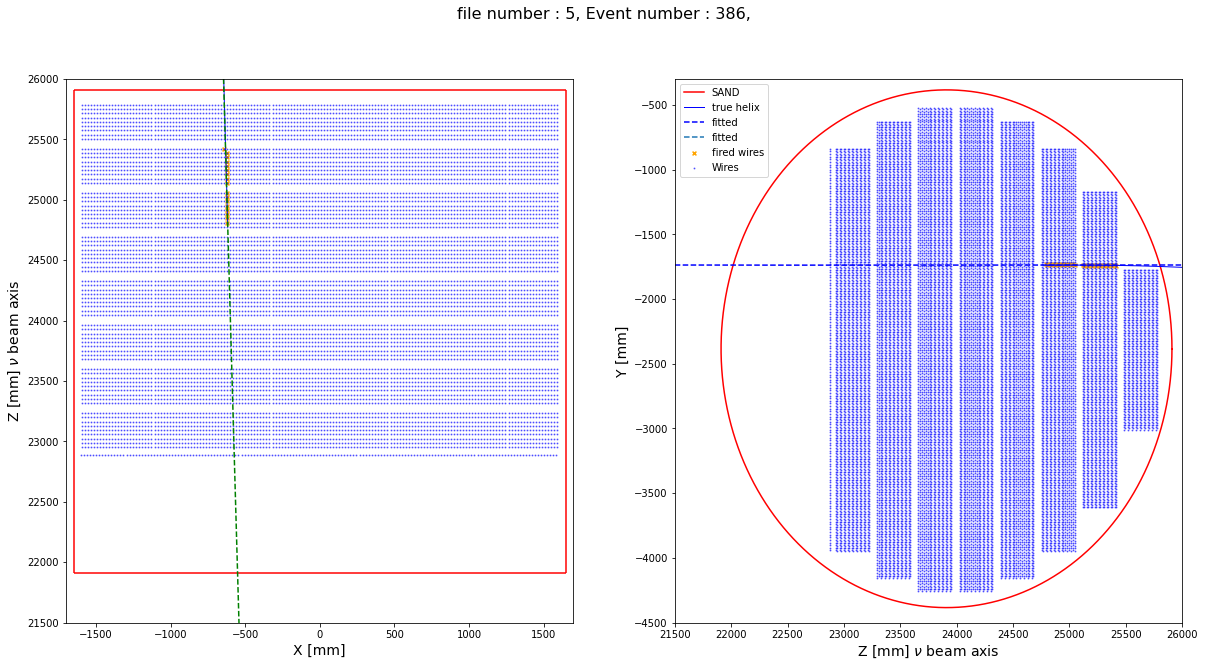

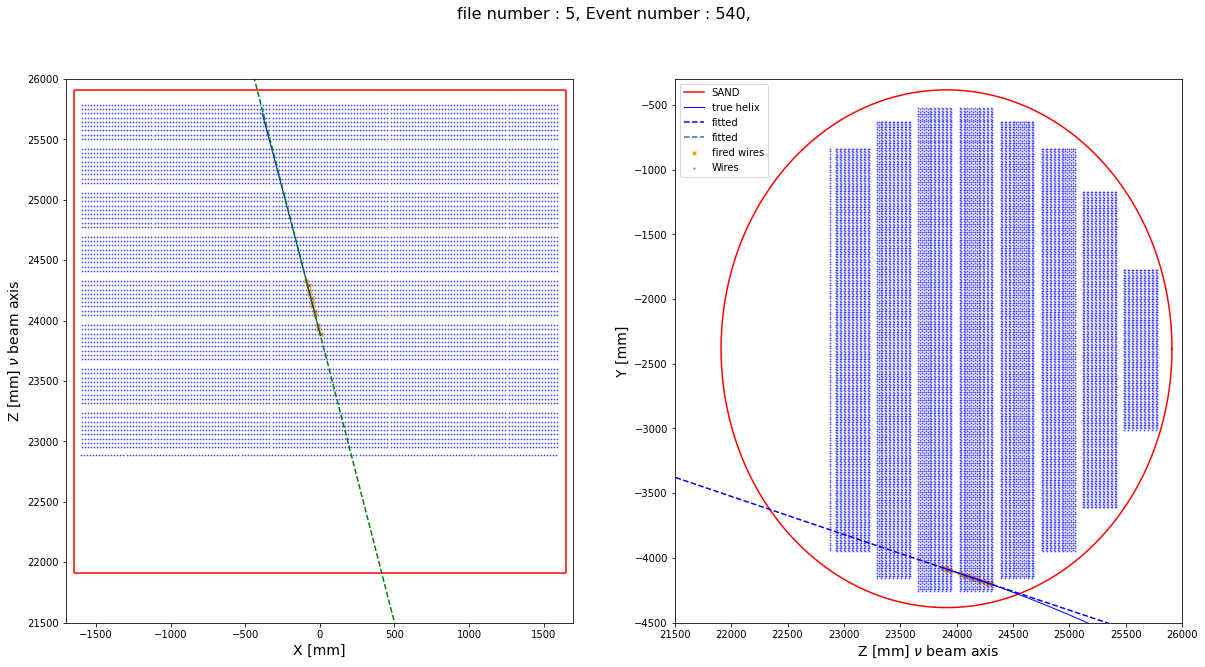

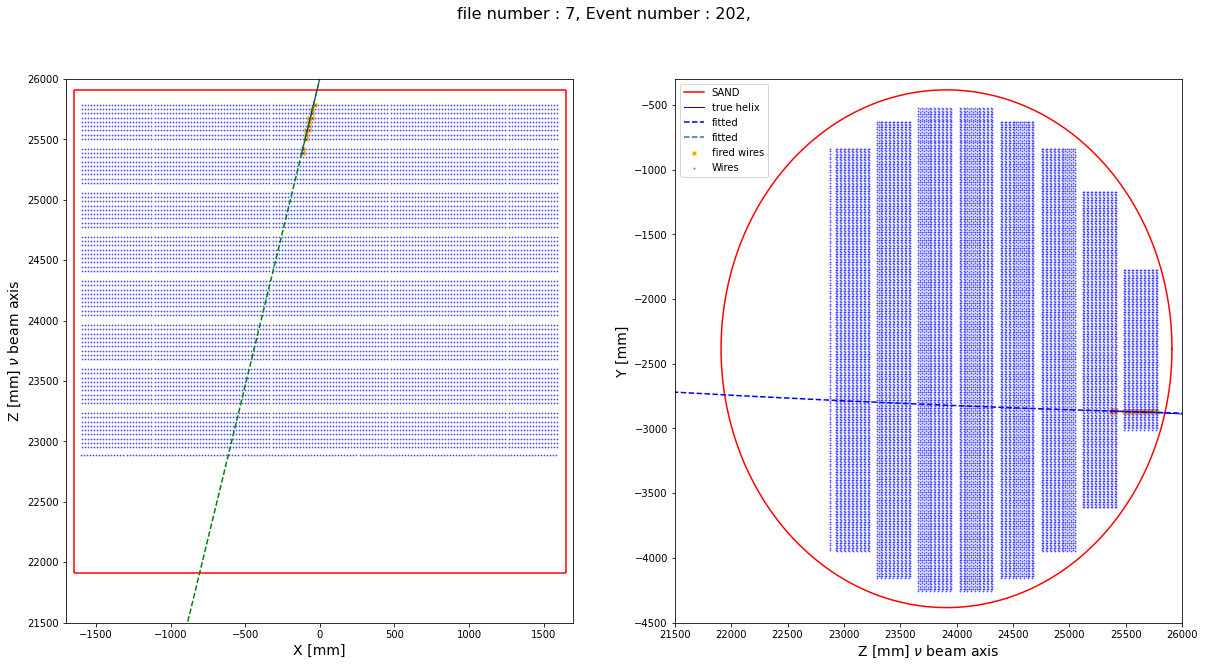

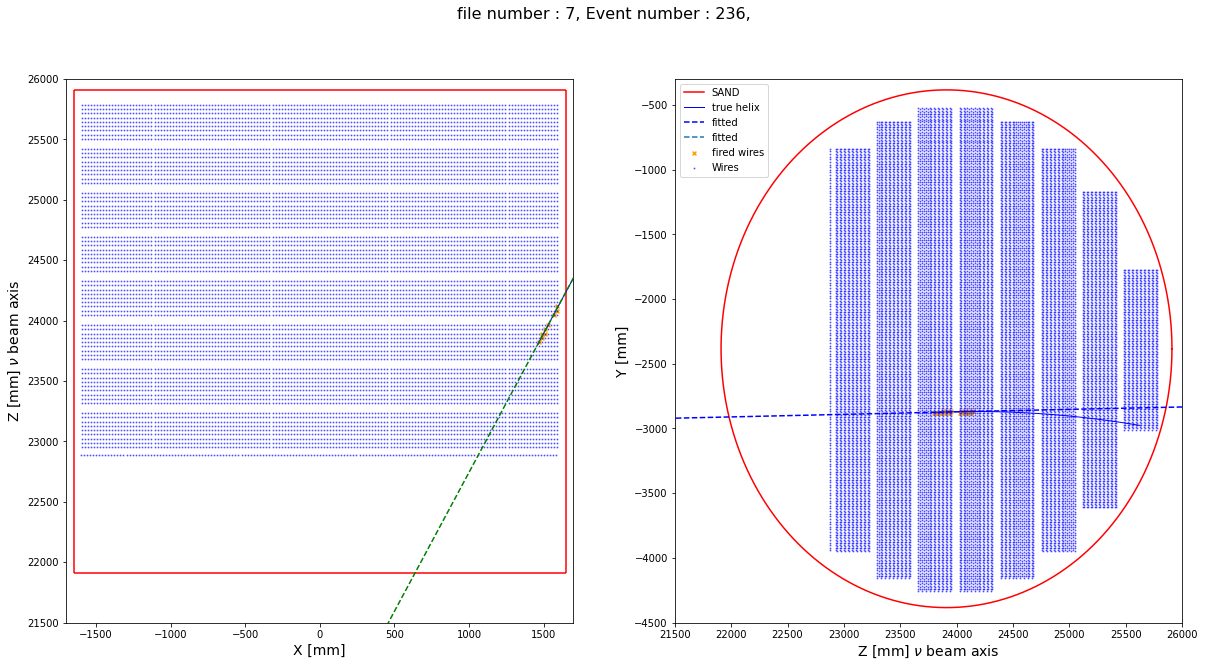

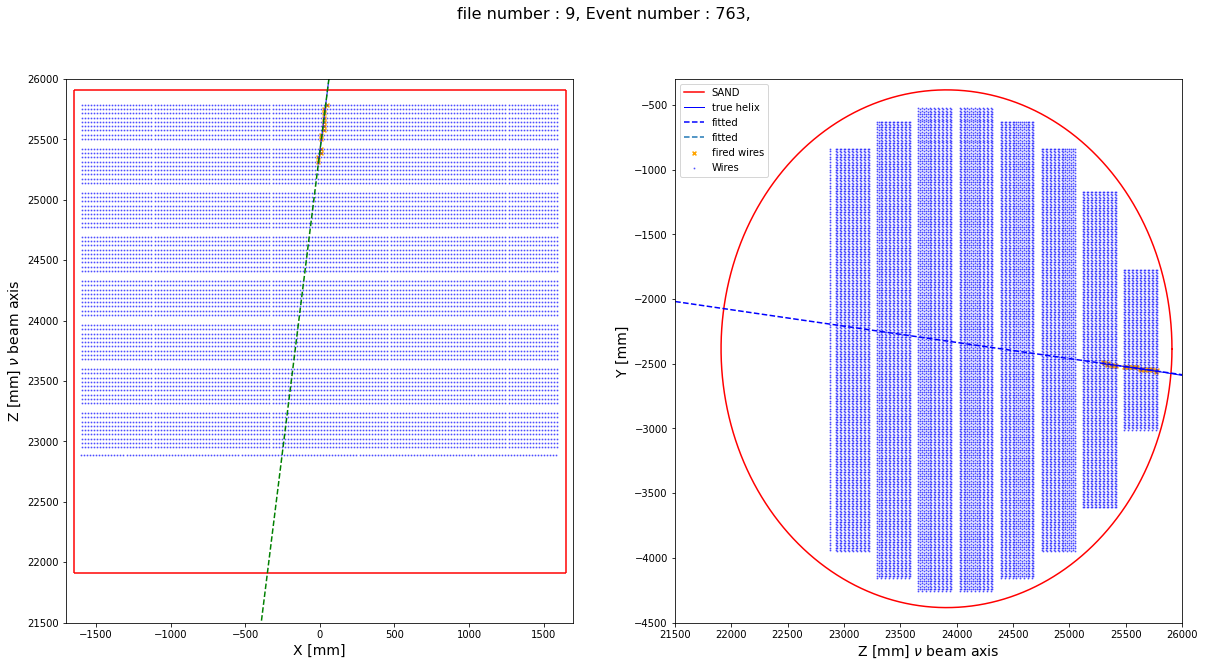

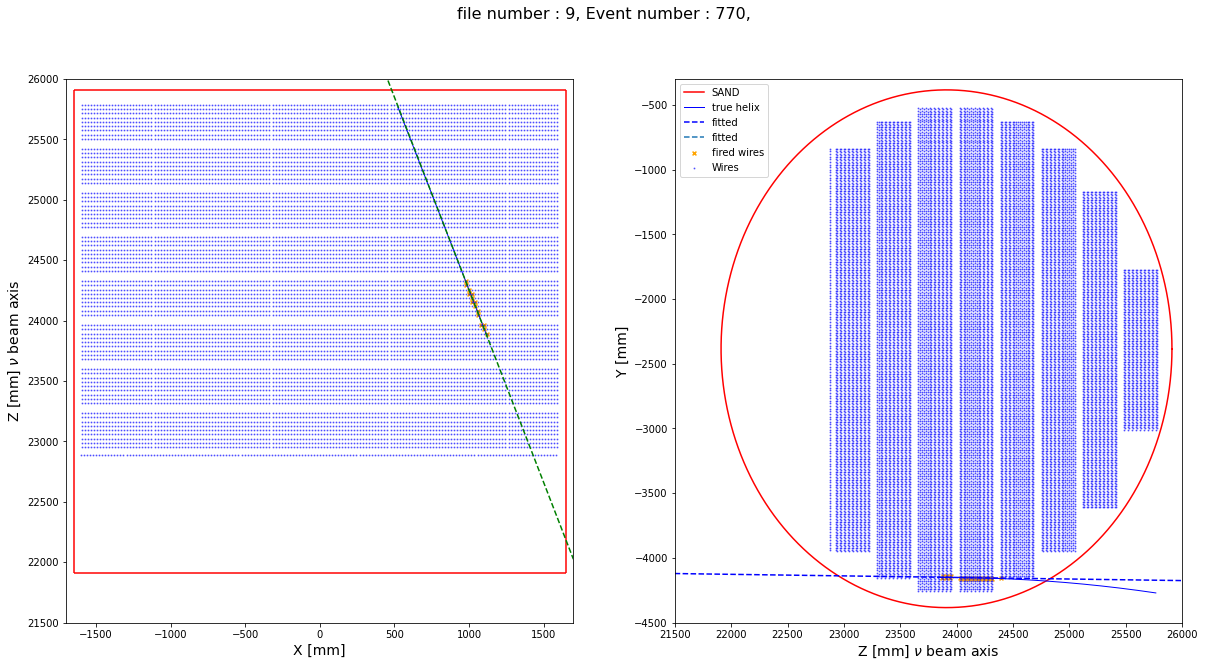

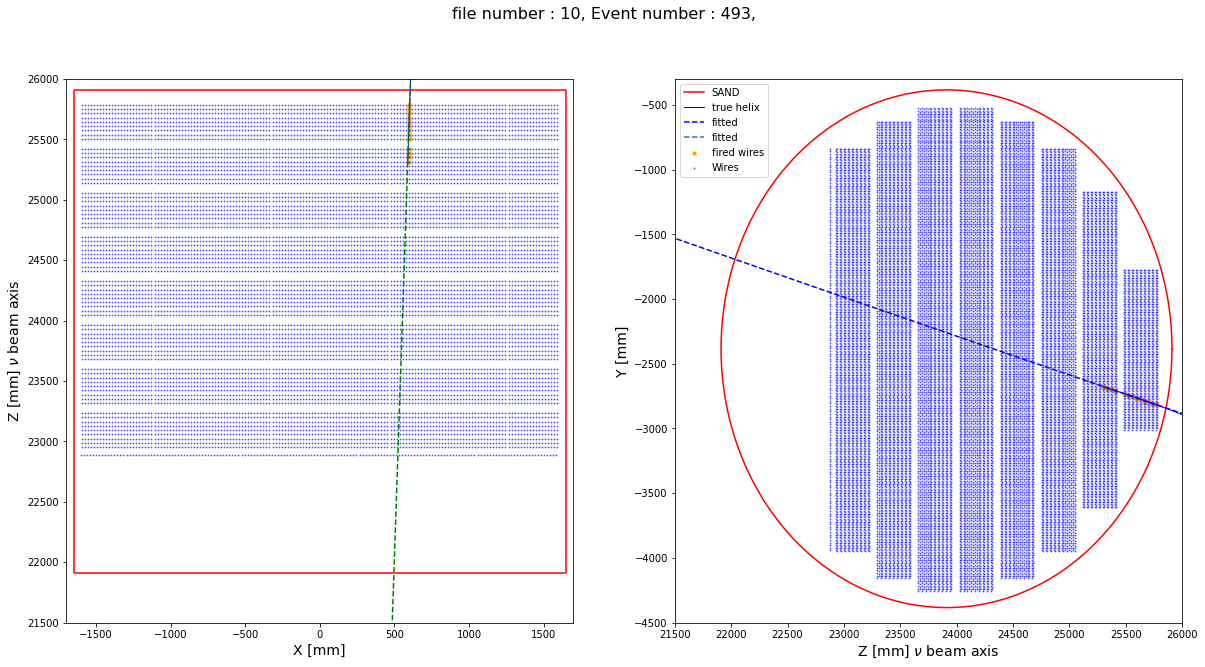

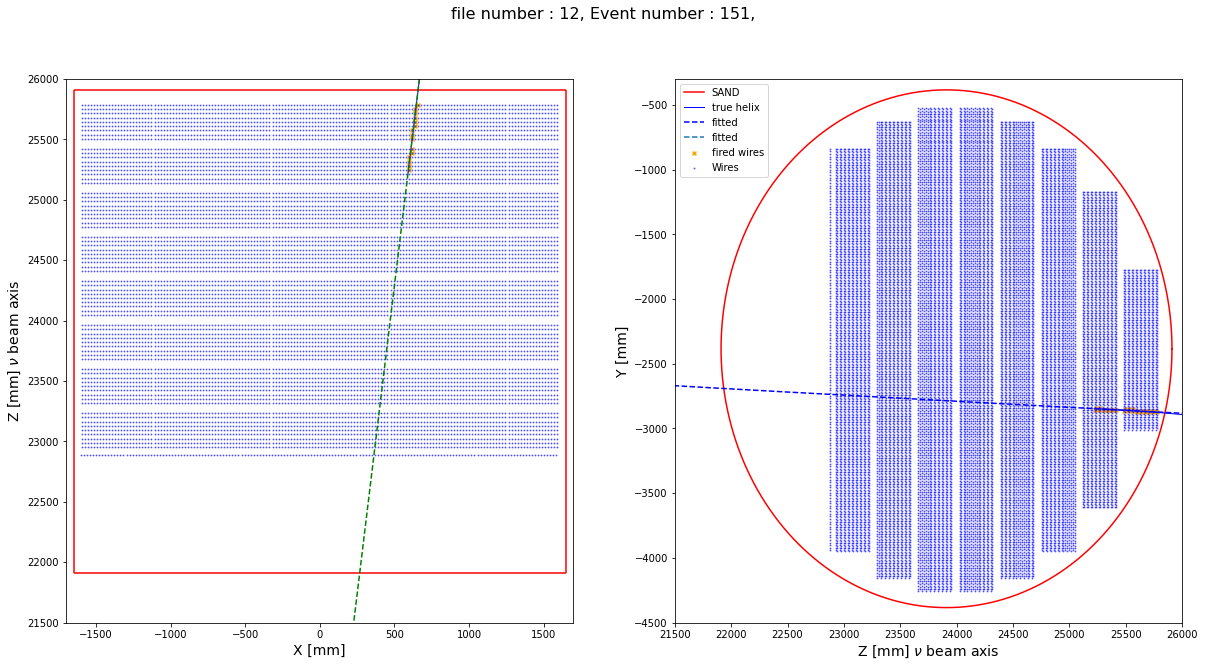

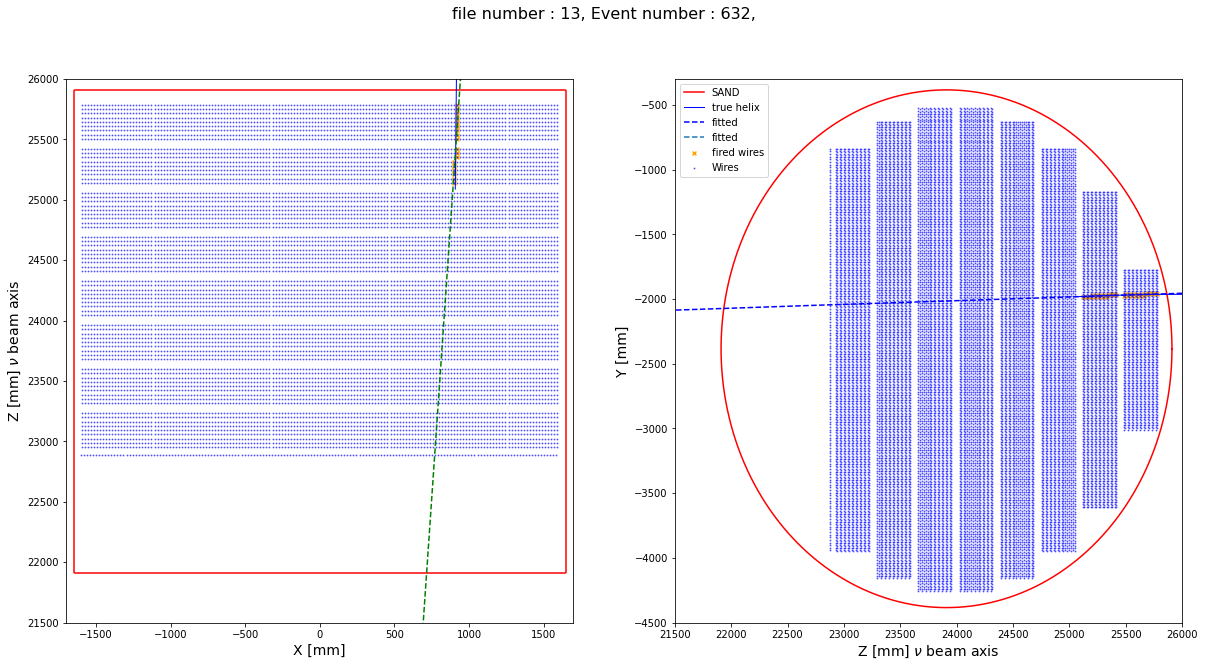

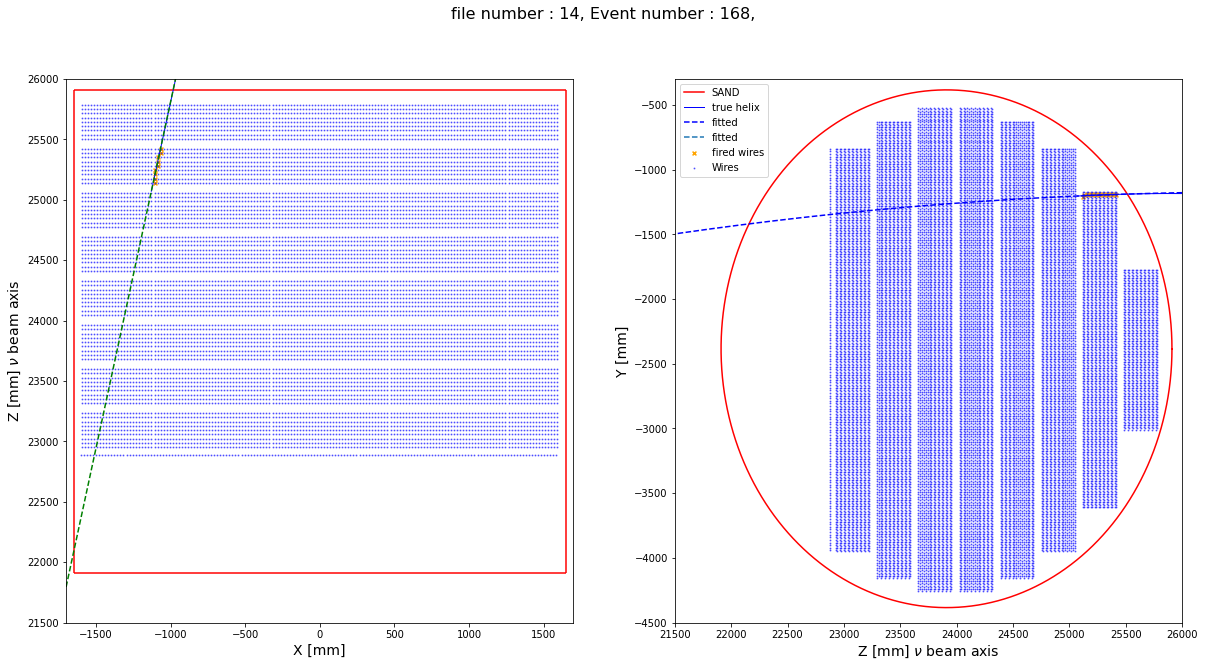

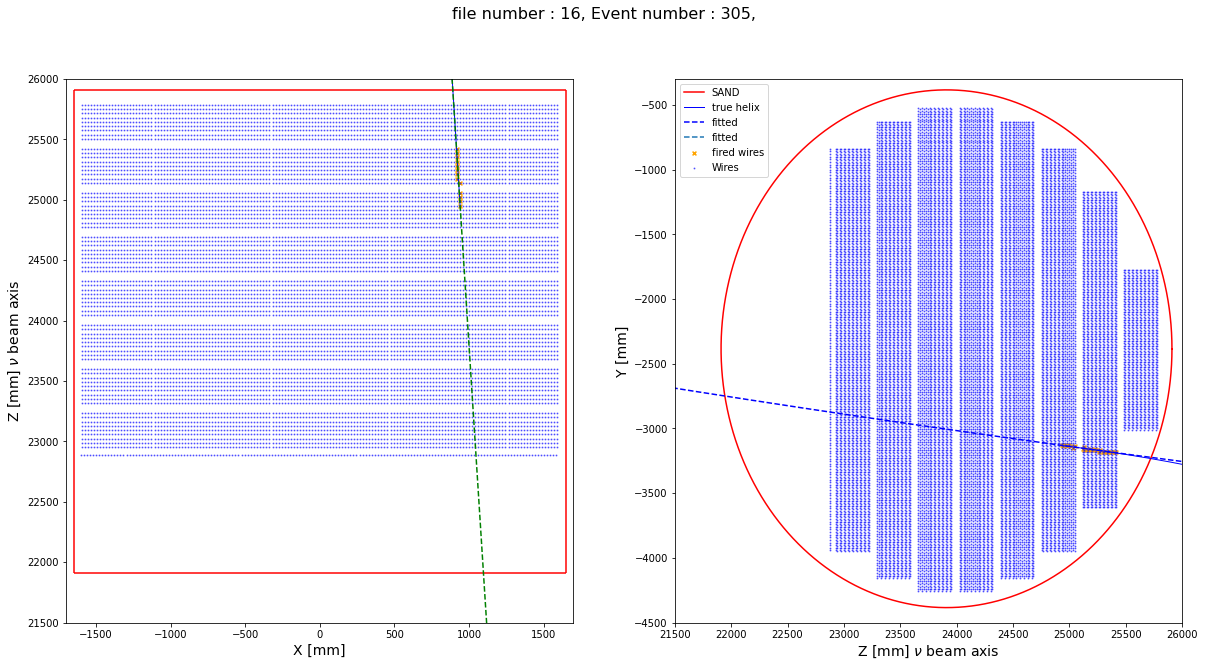

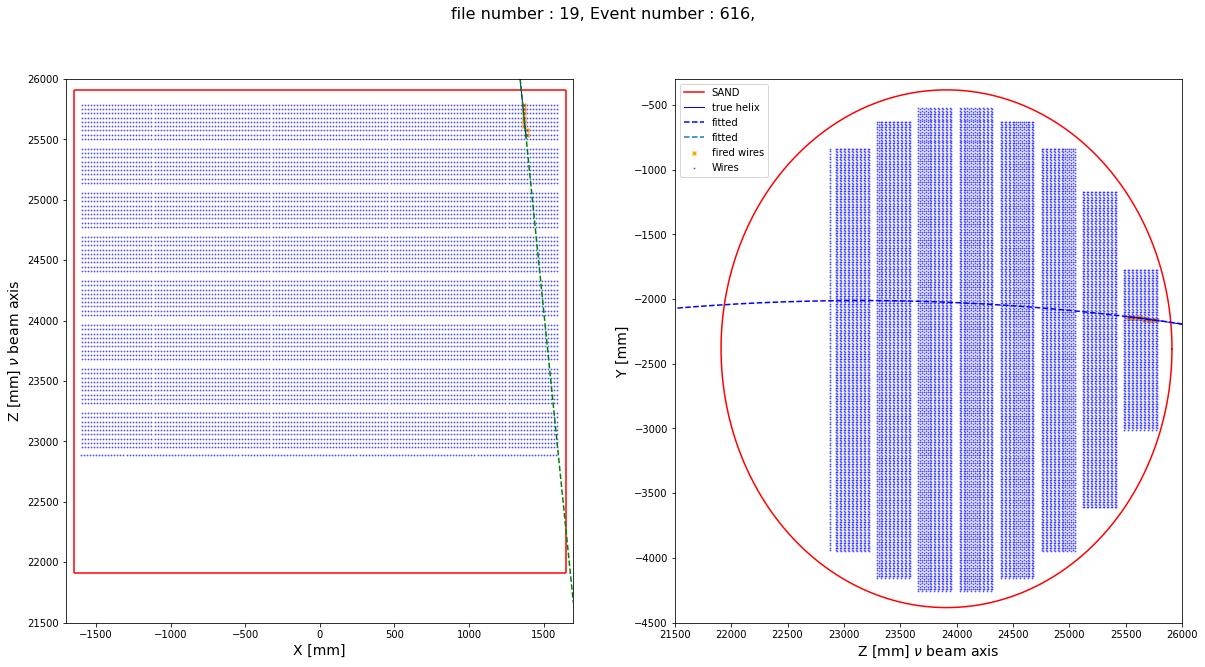

In [36]:
i=0
for _, r in some_problematic[0:15].iterrows():
    print("display {} true pt {}".format(i, r.pt_true))
    FastDisplay(edep_file = r.edep_file,
                reco_file = r.edep_file.replace('edep-sim', 'recoNLLmethod'),
                edep_event_number = r.event_index)
    i=i+1